In [660]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import re
import sys

sys.path.append(os.path.abspath("../../"))
from dataset import DS_NAMES
from dataset import DS_DIMENSIONS
from utilities.figure_tools import get_latest_results_directory, make_fig_directory, load_results

cmap = plt.get_cmap("Set1")
colors = cmap.colors

In [661]:
run_id, run_path = get_latest_results_directory("../../results/compare-methods/")
run_id = 79
run_path = "C:/Users/Peter/Documents/Peter/9-Graduate-School/2-dsrg/explainable-ad/code/HEEAD/results/compare-methods/run-079"
fig_output_path = make_fig_directory(run_id)
found_ds, results = load_results(run_path, group_field="explainer")

all_results = pd.DataFrame(columns=["dataset", "explainer", "n_samples", "n_features", "accuracy", "precision",
                               "recall", "f1", "avg_nnodes", "avg_nleaves", "avg_depth", "q", "jaccard", "coverage_ratio", "mean_distance", "mean_length", "runtime", "sample_runtime", "mdr"])

for ds in found_ds:
    results[ds]["sample_runtime"] = results[ds].runtime / (results[ds].n_samples * 0.2) * 1000 # / 20 * 1000
    results[ds]["mdr"] = results[ds].mean_distance / np.sqrt(results[ds].n_features) * 100

for ds in found_ds:
    for index, row in results[ds].iterrows():
        row["dataset"] = ds
        all_results = all_results.append(row)

found_explainers = all_results["explainer"].unique()
explainer_dict = {
    "BestCandidate" : "AFT",
    "GraphMerge" : "FACET",
    "OCEAN" : "OCEAN",
    "MACE": "MACE"
}
explainer_colors = {
    "BestCandidate" : colors[3] , # purple
    "GraphMerge" : colors[0], # red
    "OCEAN" : colors[4], # orange
    "MACE": colors[1] # blue
}
explainer_names = []
for e in found_explainers:
    explainer_names.append(explainer_dict[e])

print("Generating figures for run-{:03d}".format(run_id))
print("Datasets included:")
for ds in found_ds:
    print("\t", ds)
print("Explainers included:")
for expl in found_explainers:
    print("\t", expl)

Generating figures for run-079
Datasets included:
	 annthyroid
	 cardio
	 thyroid
Explainers included:
	 BestCandidate
	 GraphMerge
	 OCEAN


In [662]:
all_results.head()

,dataset,explainer,n_samples,n_features,accuracy,precision,recall,f1,avg_nnodes,avg_nleaves,avg_depth,q,jaccard,coverage_ratio,mean_distance,mean_length,runtime,sample_runtime,mdr
0,annthyroid,BestCandidate,7200,6,0.974788,0.991825,0.980717,0.986239,32.3,16.65,5,0.942431,0.909649,1,0.021783,1.678472,4.539009,3.152089,0.889302
1,annthyroid,GraphMerge,7200,6,0.974788,0.991825,0.980717,0.986239,32.3,16.65,5,0.942431,0.909649,1,0.017422,1.464583,1.171641,0.813640,0.711249
2,annthyroid,OCEAN,7200,6,0.974788,0.991825,0.980717,0.986239,32.3,16.65,5,0.942431,0.909649,1,0.016728,2.033333,190.000497,131.944789,0.682937
0,cardio,BestCandidate,1831,21,0.989354,0.991863,0.996438,0.994145,27.5,14.25,5.0,0.873887,0.409150,0.776567,0.392632,1.466667,1.058009,2.889156,8.567924
1,cardio,GraphMerge,1831,21,0.989354,0.991863,0.996438,0.994145,27.5,14.25,5.0,0.873887,0.409150,1.0,0.104672,1.204360,1.065884,2.910660,2.284124


In [663]:
all_results.head()

,dataset,explainer,n_samples,n_features,accuracy,precision,recall,f1,avg_nnodes,avg_nleaves,avg_depth,q,jaccard,coverage_ratio,mean_distance,mean_length,runtime,sample_runtime,mdr
0,annthyroid,BestCandidate,7200,6,0.974788,0.991825,0.980717,0.986239,32.3,16.65,5,0.942431,0.909649,1,0.021783,1.678472,4.539009,3.152089,0.889302
1,annthyroid,GraphMerge,7200,6,0.974788,0.991825,0.980717,0.986239,32.3,16.65,5,0.942431,0.909649,1,0.017422,1.464583,1.171641,0.813640,0.711249
2,annthyroid,OCEAN,7200,6,0.974788,0.991825,0.980717,0.986239,32.3,16.65,5,0.942431,0.909649,1,0.016728,2.033333,190.000497,131.944789,0.682937
0,cardio,BestCandidate,1831,21,0.989354,0.991863,0.996438,0.994145,27.5,14.25,5.0,0.873887,0.409150,0.776567,0.392632,1.466667,1.058009,2.889156,8.567924
1,cardio,GraphMerge,1831,21,0.989354,0.991863,0.996438,0.994145,27.5,14.25,5.0,0.873887,0.409150,1.0,0.104672,1.204360,1.065884,2.910660,2.284124


In [664]:
def render_bar_plot(xfeature, yfeature, xlabel, ylabel, title, save_name=None, xrange=None, yrange=None, xlog=False):
    fig, ax = plt.subplots()
    pos = np.arange(len(found_ds))
    bar_width = 0.15

    yvalues = all_results[yfeature].unique()

    for i in range(len(yvalues)):
        isExpl = all_results[yfeature] == yvalues[i]
        ax.barh(y=(pos + bar_width*i), width=all_results[isExpl][xfeature], height=bar_width, log=xlog, color=explainer_colors[yvalues[i]])
        print(yfeature)

    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend(explainer_names,loc="best")
    plt.yticks(pos, found_ds)

    if save_name is not None:
        plt.savefig(fig_output_path + "/" + save_name)

explainer
explainer
explainer


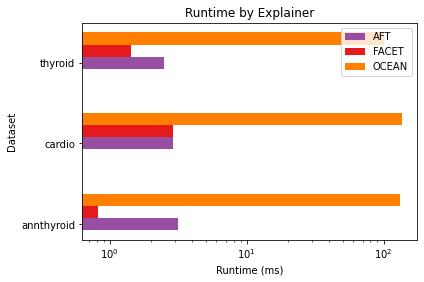

In [665]:
render_bar_plot("sample_runtime", "explainer", "Runtime (ms)", "Dataset", "Runtime by Explainer", "runtime.png", xlog=True)

explainer
explainer
explainer


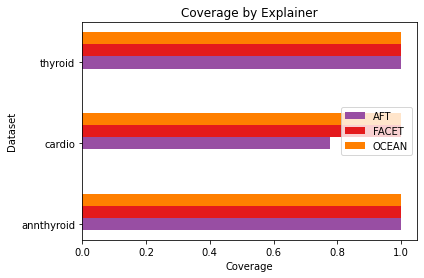

In [666]:
render_bar_plot("coverage_ratio", "explainer", "Coverage", "Dataset", "Coverage by Explainer", "coverage.png")

explainer
explainer
explainer


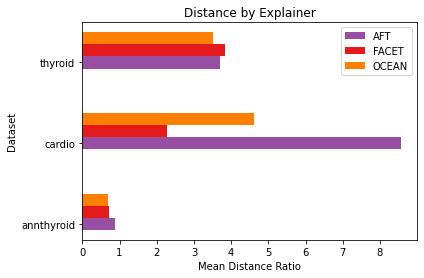

In [667]:
render_bar_plot("mdr", "explainer", "Mean Distance Ratio", "Dataset", "Distance by Explainer", "distance.png")

explainer
explainer
explainer


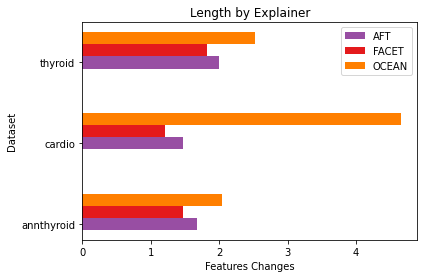

In [668]:
render_bar_plot("mean_length", "explainer", "Features Changes", "Dataset", "Length by Explainer", "length.png")

In [669]:
# Classification performance

md_table_path = fig_output_path + "/results.md"
f = open(md_table_path, "w")

metrics = ["f1", "avg_nnodes", "avg_nleaves", "avg_depth", "q", "jaccard"]
formats = ["{v:0.2f}", "{v:0.2f}", "{v:0.2f}", "{v:0.2f}", "{v:0.2f}", "{v:0.2f}"]

f.write("| dataset | n | p | f1 | nNodes | nLeaves | depth | Q | J |\n")
f.write("|---------|---|---|----|--------|---------|-------|---|---|\n")

for ds in found_ds:
    n = DS_DIMENSIONS[ds][0]
    p = DS_DIMENSIONS[ds][1]
    f.write("| {ds} | {n} | {p}".format(ds=ds, n=n, p=p))
    for i in range(len(metrics)):
        metric = metrics[i]
        isexpl = results[found_ds[0]]["explainer"] == found_explainers[0]
        val = results[ds][isexpl][metric].to_numpy()[0]
        f.write((" | " + "{v:0.2f}" + "").format(v=val))
    f.write(" |")
    f.write("\n")

# Explanation performance
f.write("\n\n")
metrics = ["coverage_ratio", "sample_runtime", "mean_length", "mdr"]
scales = [100, 1, 1, 1]
f.write("|            |       |     | AFT    | FACET  | AFT   | FACET | AFT   | FACET | AFT   | FACET  |\n")
f.write("| ---------- | ----- | --- | ------ | ------ | ----- | ----- | ----- | ----- | ----- | ------ |\n")
f.write("| Dataset    | n     | p   | C      | C      | R     | R     | L     | L     | D     | D      |\n")

for ds in found_ds:
    n = DS_DIMENSIONS[ds][0]
    p = DS_DIMENSIONS[ds][1]
    f.write("| {ds} | {n} | {p}".format(ds=ds, n=n, p=p))
    for i in range(len(metrics)):
        metric = metrics[i]
        scale = scales[i]
        for explainer in found_explainers:
            isexpl = results[found_ds[0]]["explainer"] == explainer
            val = results[ds][isexpl][metric].to_numpy()[0]
            f.write(" | {v:0.2f}".format(v=val * scale))
    f.write(" |")
    f.write("\n")

f.close()